# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [371]:
# Import libraries
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [372]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype)
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype)
I = torch.eye(2, dtype=exp_dtype)

-0.09316538792974853


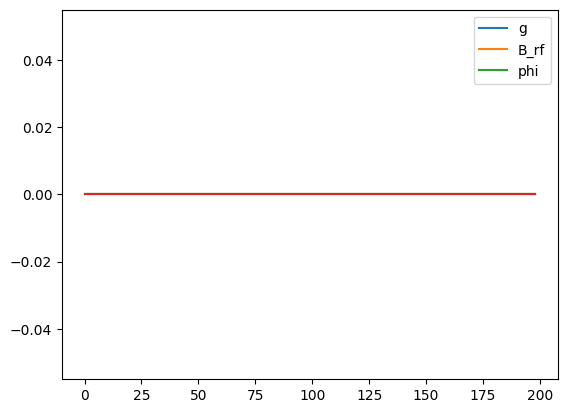

In [373]:
# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 0.5e-8
t_units = np.arange(Ti, Tf-dt, dt)
M = int((Tf - Ti) // dt)
t = np.arange(M) 

# Plotting help
def bloch_animation(rhos, plot=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, np.array([[0, 1], [1, 0]]))))
        Y = np.real(np.trace(np.dot(rho, np.array([[0, -1j], [1j, 0]]))))
        Z = np.real(np.trace(np.dot(rho, np.array([[1, 0], [0, -1]]))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    if plot:
        plt.plot(t_units, x, c='r', label=r"$x(t)$")
        plt.plot(t_units, y, c='b', label=r"$y(t)$")
        plt.plot(t_units, z, c='g', label=r"$z(t)$")
        plt.title("State Vector")
        plt.legend(loc='best')
        plt.savefig("./results/xyz_state.png", dpi=300, bbox_inches="tight")
        plt.show()

        plt.plot(t_units, r, c='k', label=r"$r(t)$")
        plt.title("R Value")
        plt.legend(loc='best')
        plt.savefig("./results/r_value.png", dpi=300, bbox_inches="tight")
        plt.show()


        print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
        print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")
    else:
        return r
    
# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K
Te = 0.1 # Electron temp

w = 2 * muB * B0 / hbar # Larmor freq

on_resonance = False

f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(on_resonance) else w 
# print(w, w_rf)
# Define control parameters
g = np.zeros(M)
B_rf = np.zeros(M) 
# offset_phi = True
phi = np.zeros(M) 
# phi_scale = 1/(np.pi/4) if offset_phi else 0
J = np.zeros(M)

print((w-w_rf)/1e9)
# Interpolate to give it some shape
interp_step = M // 2
scale = 10000

def interpolate_parameter(param, t, interp_step, scale):
    param[::interp_step] = np.random.rand(M // interp_step + 1) / scale # T
    param[0] = 0
    param[-1] = 0
    param = CubicSpline(t[::interp_step], param[::interp_step])
    return param(t)

# B_rf = interpolate_parameter(B_rf, t, interp_step, scale)
# g = interpolate_parameter(g, t, interp_step, scale)
# if offset_phi:
#     phi = interpolate_parameter(phi, t, interp_step, 1/np.pi)
# J = interpolate_parameter(J, t, interp_step, scale)

plt.plot(g, label="g")
plt.plot(B_rf, label="B_rf")
plt.plot(phi, label="phi")
plt.plot(J)
plt.legend(loc="best")
plt.show()

# Convert to optimization variables with torch properties
g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)
J = Variable(torch.tensor(J, dtype=exp_dtype), requires_grad=True)


In [374]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)

# Define Lindblad operators
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up
T1 = 1e-3
T2 = 1e-6

L1 = np.sqrt(P_up / (2 * T1)) * sigma_plus
L2 = np.sqrt(P_down / (2 * T1)) * sigma_minus
L3 = sigma_z / (2 * np.sqrt(T2))

L = [L1, L2, L3]

# Construct total matrix
L_total = torch.zeros(4, 4, dtype=exp_dtype)
for i in range(len(L)):
    L_total += 2 * kron(L[i], torch.conj(L[i])) - kron(torch.matmul(hermitian_conj(L[i]), L[i]), I) - kron(I, torch.matmul(L[i].transpose(0,1), torch.conj(L[i])))


In [375]:
# Construct superoperator
def L_F(g, B_rf, phi, J, L, dispersive=False):
    Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
    for i in range(M):
        H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]) * sigma_x + torch.sin(phi[i]) * sigma_y)
        Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
    exp_Gamma = torch.matrix_exp(Gamma * dt)
    product = torch.eye(4, dtype=exp_dtype)
    for matrix in exp_Gamma: # Use torch.einsum? 
        product = torch.mm(product, matrix)
    return product

# Evolves rho at each time step and concatonates into an array
def evolve_rho(rho0, B_rf, g, phi, dispersive=False):
    rhos = torch.zeros((M, 2, 2), dtype=exp_dtype)
    rhos[0] = rho0
    Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
    for i in range(M):
        H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]).item() * sigma_x + torch.sin(phi[i]).item() * sigma_y)
        Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
    exp_Gamma = torch.matrix_exp(Gamma * dt)
    for i in range(1,M): # should be more efficient way
        rhos[i] = torch.matmul(exp_Gamma[i], rhos[i-1].view(-1,)).view(2,2)
    return rhos, rhos.detach().numpy()

### Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
def RY(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
theta =np.pi/2
UF = RY(theta)

L_desired = kron(UF.conj(), UF)

# Check out density matrices
rho0 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            L_F(g, B_rf, phi, J, L), rho0.view(-1,)
        )

print(L_F(g, B_rf, phi, J, L))
print(L_desired)
print(rho_desired.view(2,2))
print(rho.view(2,2))



tensor([[1.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0226-0.9997j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0226+0.9997j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 1.0000+0.0000j]],
       dtype=torch.complex128, grad_fn=<MmBackward0>)
tensor([[ 0.5000+0.j, -0.5000+0.j, -0.5000-0.j,  0.5000+0.j],
        [ 0.5000+0.j,  0.5000+0.j, -0.5000-0.j, -0.5000-0.j],
        [ 0.5000+0.j, -0.5000+0.j,  0.5000+0.j, -0.5000+0.j],
        [ 0.5000+0.j,  0.5000+0.j,  0.5000+0.j,  0.5000+0.j]],
       dtype=torch.complex128)
tensor([[0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j]], dtype=torch.complex128)
tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], dtype=torch.complex128, grad_fn=<ViewBackward0>)


In [376]:
from torch.fft import fft

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def forward(self, output, target, opt_params):

        fidelity = (torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / 4)

        loss = nn.L1Loss()

        g, B_rf, phi = opt_params

        # rho, _ = evolve_rho(rho0, B_rf, g, phi, dispersive=False)

        # rhos_new = torch.zeros((M, 2, 2), dtype=exp_dtype)
        # rhos_new[0] = rho0.clone()
        # Gamma_new = torch.zeros((M, 4, 4), dtype=exp_dtype)
        # for i in range(M):
        #     H_rf_new = 0.5 * ((1 + g[i].clone()/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i].clone() * (torch.cos(phi[i].clone()).item() * sigma_x + torch.sin(phi[i].clone()).item() * sigma_y)
        #     Gamma_new[i] = -1j * (kron(H_rf_new, I) - kron(I, H_rf_new.transpose(0,1))) + L_total if False else -1j * (kron(H_rf_new, I) - kron(I, H_rf_new.transpose(0,1)))
        # exp_Gamma_new = torch.matrix_exp(Gamma_new * dt)
        # for i in range(1,M):
        #     rhos_new[i] = torch.matmul(exp_Gamma_new[i], rhos_new[i-1].view(-1,)).view(2,2)
        # # with torch.no_grad():

        # R_array = bloch_animation(rhos_new.detach().numpy(), plot=False)
        # # print(R_array)
        # # print(rho_trace)
        # R_avg = torch.sum(torch.Tensor(R_array)) / M
      
        # # # Compute the real FFT of the signal along the last dimension
        # spectrum = torch.norm(torch.abs(fft(B_rf, dim=-1)[M//2::]))

        # # Compute the penalty term as the L2 norm of the derivative of the spectrum
        # freq_penalty = spectrum

        penalty = 1e8
        cost_start_stop = 0
 
        cost_start_stop += penalty * torch.sum(torch.square(torch.abs(g[0])) + torch.square(torch.abs(g[-1]))).real
        cost_start_stop += penalty * torch.sum(torch.square(torch.abs(B_rf[0])) + torch.square(torch.abs(B_rf[-1]))).real

        return  1 * torch.square(fidelity-1) + loss(output,target) + cost_start_stop, fidelity, -1
        # return 1 * torch.square(fidelity-1) + 1 * loss(output, target) + cost_start_stop + 0 * torch.norm(g)**2 + 10 * torch.square(R_avg-1), fidelity, R_avg

opt_params = [g, B_rf, phi]
lr_dict = {'g': 1e-6, 'B_rf': 1e-6, 'phi': 1e-2}
optimizer = torch.optim.Adam([{'params': g, 'lr': lr_dict['g']},
                              {'params': B_rf, 'lr': lr_dict['B_rf']},
                              {'params': phi, 'lr': lr_dict['phi']}])
criterion = CostFunction()
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.6)

epochs = 500
loss_array = []
for i in range(epochs):
    optimizer.zero_grad()
    L_output = L_F(g, B_rf, phi, J, L)
    loss, fid, R_avg = criterion(L_output, L_desired, opt_params)
    
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
 
    if i % 100 == 0:
        print("Step {}: Loss = {}, Fidelity = {}, R Average = {}".format(i, loss.item(), fid,R_avg))

print("Output superoperator: ", L_F(g, B_rf, phi, J, L), L_desired)
print("Final Fidelity = ", fid)

Step 0: Loss = 1.1300524057120023, Fidelity = 0.2556439477685312, R Average = -1
Step 100: Loss = 0.005942907079448784, Fidelity = 1.0000557215249077, R Average = -1
Step 200: Loss = 0.003616432926090827, Fidelity = 1.0000071269019972, R Average = -1
Step 300: Loss = 0.004119763031895785, Fidelity = 0.9999782690388401, R Average = -1
Step 400: Loss = 0.004053302059865457, Fidelity = 0.9999802693724102, R Average = -1
Output superoperator:  tensor([[ 0.5047-0.0024j, -0.4961-0.0002j, -0.5039+0.0002j,  0.4953+0.0024j],
        [ 0.4980-0.0027j,  0.4989-0.0050j, -0.4972+0.0005j, -0.4980+0.0027j],
        [ 0.5019+0.0028j, -0.4934-0.0054j,  0.5106+0.0002j, -0.5019-0.0028j],
        [ 0.4953+0.0024j,  0.4961+0.0002j,  0.5039-0.0002j,  0.5047-0.0024j]],
       dtype=torch.complex128, grad_fn=<MmBackward0>) tensor([[ 0.5000+0.j, -0.5000+0.j, -0.5000-0.j,  0.5000+0.j],
        [ 0.5000+0.j,  0.5000+0.j, -0.5000-0.j, -0.5000-0.j],
        [ 0.5000+0.j, -0.5000+0.j,  0.5000+0.j, -0.5000+0.j],
   

Output superoperator, 
  tensor([[ 0.5047-0.0024j, -0.4961-0.0002j, -0.5039+0.0002j,  0.4953+0.0024j],
        [ 0.4980-0.0027j,  0.4989-0.0050j, -0.4972+0.0005j, -0.4980+0.0027j],
        [ 0.5019+0.0028j, -0.4934-0.0054j,  0.5106+0.0002j, -0.5019-0.0028j],
        [ 0.4953+0.0024j,  0.4961+0.0002j,  0.5039-0.0002j,  0.5047-0.0024j]],
       dtype=torch.complex128, grad_fn=<MmBackward0>)
Desired superoperator, 
  tensor([[ 0.5000+0.j, -0.5000+0.j, -0.5000-0.j,  0.5000+0.j],
        [ 0.5000+0.j,  0.5000+0.j, -0.5000-0.j, -0.5000-0.j],
        [ 0.5000+0.j, -0.5000+0.j,  0.5000+0.j, -0.5000+0.j],
        [ 0.5000+0.j,  0.5000+0.j,  0.5000+0.j,  0.5000+0.j]],
       dtype=torch.complex128)


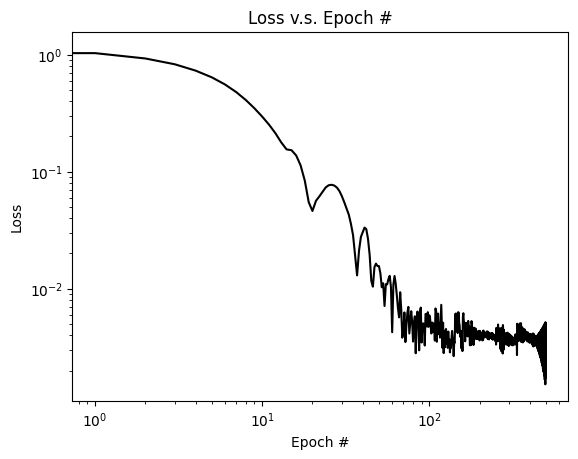

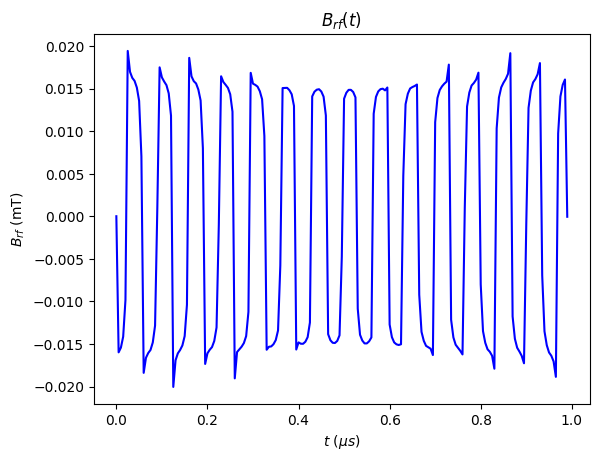

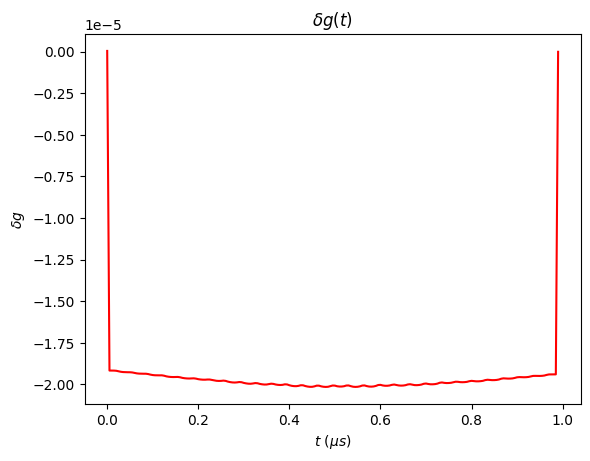

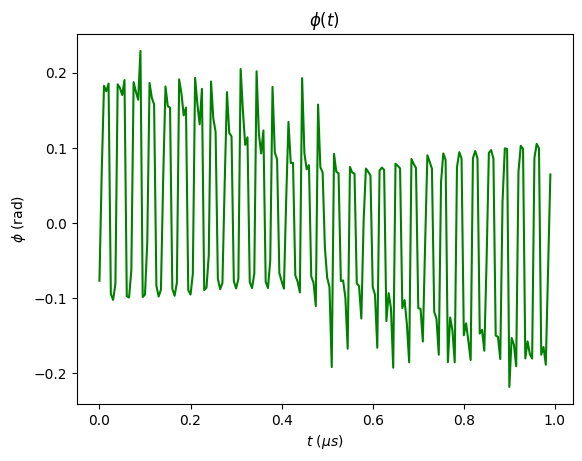

tensor([[0.4984+0.0008j, 0.5009+0.0013j],
        [0.4991-0.0013j, 0.5016-0.0008j]], dtype=torch.complex128,
       grad_fn=<ViewBackward0>)


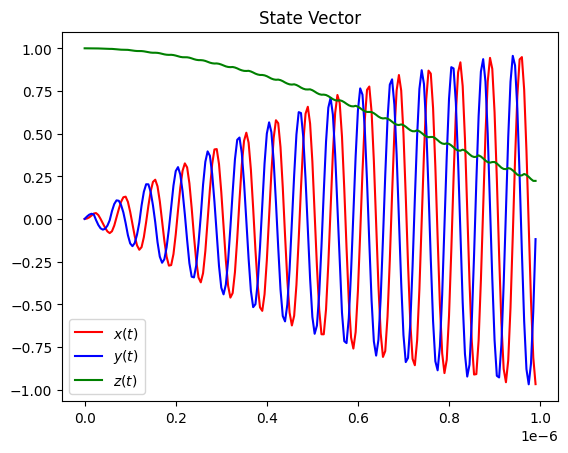

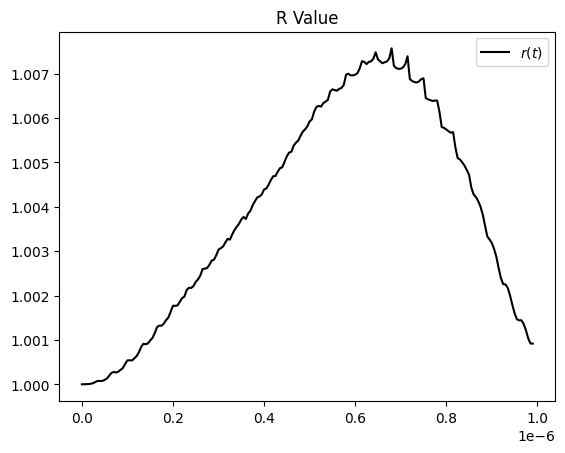

Starting: [0.0, 0.0, 1.0] 

Ending: [-0.9685620382592176, -0.1184051218673466, 0.22294637477591162]


In [377]:
print("Output superoperator, \n ", L_F(g, B_rf, phi, J, L))
print("Desired superoperator, \n ", L_desired)


# Print cost fxn 
plt.loglog(range(epochs), loss_array, 'k')
plt.title("Loss v.s. Epoch #")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig('./results/loss.png', dpi=350, bbox_inches="tight")
plt.show()

# Show trained parameters
plt.plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
plt.title(r"$B_{rf}(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$B_{rf}\ $(mT)")
plt.savefig('./results/B_rf.png', dpi=350, bbox_inches="tight")
plt.show() 

plt.plot(1e6 * t_units, g.detach().numpy(), 'r')
plt.title(r"$\delta g(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\delta g$")
plt.savefig('./results/delta_g.png', dpi=350, bbox_inches="tight")
plt.show() 

plt.plot(1e6 * t_units, phi.detach().numpy(), 'g')
plt.title(r"$\phi(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\phi$ (rad)")
plt.savefig('./results/phi.png', dpi=350, bbox_inches="tight")
plt.show()

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )
print(rho_out.view(2,2))

# Evolve rho
rhos_tens, rhos_numpy = evolve_rho(rho0, B_rf, g, phi, dispersive=False)

bloch_animation(rhos_numpy, plot=True)